In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import MENDER
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from scipy import stats

path_to_dataset = r"tnbc.h5ad"

In [46]:
adata = sc.read_h5ad(path_to_dataset)
# print(adata.obs)
adata.obs

,SampleID,cellLabelInImage,cellSize,C,Na,Si,P,Ca,Fe,Background,...,immuneGroup,group_name,immuneGroup_name,all_group_name,leiden,x,y,scNiche,subtype,all_group_name2
Cell1,1,2,146,0,-0.59061,0.875220,-2.57650,-0.806060,-0.23440,-0.843460,...,0,Keratin+ tumor,NonImmune,Keratin+ tumor,3,158.335616,32.856164,Niche10,Mixed,Tumor
Cell2,1,3,102,0,-0.49870,0.017464,-1.22490,-0.501520,-1.34120,-0.376830,...,4,Immune,CD3 T,CD3 T,1,191.294118,30.588235,Niche10,Mixed,Immune
Cell3,1,4,43,0,-1.48730,-0.630440,-1.91070,-1.228000,-1.39370,-0.089412,...,0,Keratin+ tumor,NonImmune,Keratin+ tumor,3,212.325581,30.232558,Niche10,Mixed,Tumor
Cell4,1,5,211,0,-1.00530,-0.532270,-1.74300,-0.944850,-1.09960,-0.203970,...,0,Keratin+ tumor,NonImmune,Keratin+ tumor,4,269.985782,34.772512,Niche10,Mixed,Tumor
Cell5,1,6,177,0,0.15803,-0.710290,0.51737,-0.096251,-1.05260,1.097800,...,6,Immune,B,B,0,381.175141,35.344633,Niche10,Mixed,Immune
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell195949,41,5093,90,0,-0.31842,0.332450,-1.60410,0.444140,0.62615,-0.170790,...,0,Keratin+ tumor,NonImmune,Keratin+ tumor,1,1121.822222,2015.266667,Niche8,Compartmentalized,Tumor
Cell195950,41,5094,132,0,0.30404,1.467600,-2.16650,0.597130,0.35472,1.408900,...,0,Tumor,NonImmune,Tumor,5,1200.250000,2016.022727,Niche10,Compartmentalized,Tumor
Cell195951,41,5095,123,0,-0.39525,-0.146200,-1.89770,0.192400,0.43584,0.382950,...,8,Immune,Macrophages,Macrophages,10,1242.065041,2014.837398,Niche1,Compartmentalized,Immune
Cell195952,41,5096,99,0,-0.75282,0.494750,-1.52110,0.458440,0.38360,0.147050,...,12,Immune,Other immune,Other immune,7,1573.232323,2015.101010,Niche0,Compartmentalized,Immune


In [4]:
print(adata.obs.columns)

Index(['SampleID', 'cellLabelInImage', 'cellSize', 'C', 'Na', 'Si', 'P', 'Ca',
       'Fe', 'Background', 'B7H3', 'OX40', 'CD163', 'CSF.1R', 'Ta', 'Au',
       'tumorYN', 'tumorCluster', 'Group', 'immuneCluster', 'immuneGroup',
       'group_name', 'immuneGroup_name', 'all_group_name', 'leiden', 'x', 'y',
       'scNiche', 'subtype', 'all_group_name2'],
      dtype='object')


Sample IDs: [5, 13]
Plotting SampleID: 5


/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


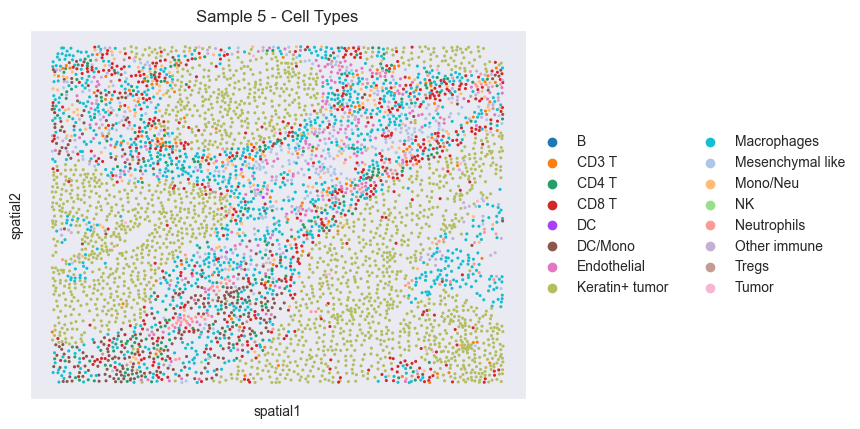

Plotting SampleID: 13


/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


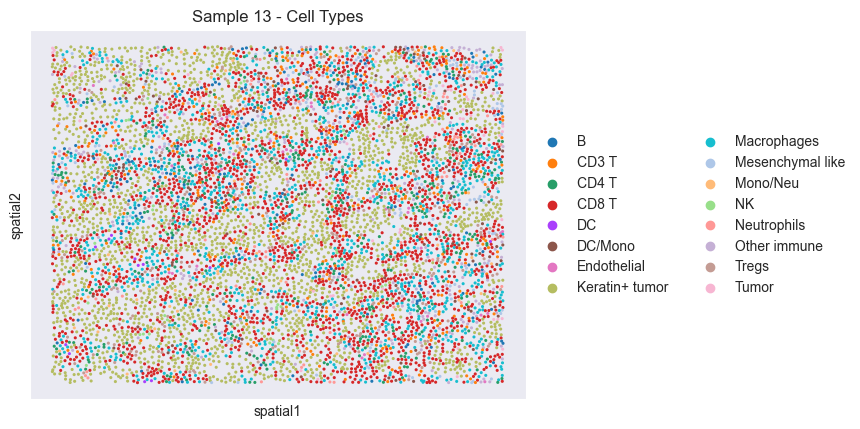

In [47]:
sample_ids = adata.obs['SampleID'].unique()

# 5 AND 13 ARE THE ONES THEY USE IN THE PAPER FIGURES!!!
sample_ids = [5, 13]
print("Sample IDs:", sample_ids)
# subtypes = ['Mixed', 'Compartmentalized']
# for subtype in subtypes:
#     print(f"Plotting subtype: {subtype}")
#     adata_slice = adata[adata.obs['subtype'] == subtype].copy()
#     # Create the plot
#     ax = sc.pl.embedding(
#         adata_slice,
#         basis='spatial',
#         color='all_group_name',
#         title=f"Sample {subtype} - Cell Types",
#         size=20,
#         show=False  # Prevents showing immediately
#     )
#
#     # Flip the Y-axis (THIS IS WHAT THEY HAVE IN THE PAPER FOR SOME REASON)
#     plt.gca().invert_yaxis()
#
#     # Now show the modified plot
#     plt.show()

for sample_id in sample_ids:
    print(f"Plotting SampleID: {sample_id}")
    adata_slice = adata[adata.obs['SampleID'] == sample_id].copy()

    # Create the plot
    ax = sc.pl.embedding(
        adata_slice,
        basis='spatial',
        color='all_group_name',
        title=f"Sample {sample_id} - Cell Types",
        size=20,
        show=False  # Prevents showing immediately
    )

    # Flip the Y-axis (THIS IS WHAT THEY HAVE IN THE PAPER FOR SOME REASON)
    plt.gca().invert_yaxis()

    # Now show the modified plot
    plt.show()


In [48]:
adata_raw = adata.copy()
batch_obs = 'subtype'
scale = 6
radius = 15

# I'm not sure why they did so many copies but I took it from this code 
# https://mender-tutorial.readthedocs.io/en/latest/MERSCOPE.html
adata = adata_raw.copy()

# adata.obs['SampleID'] = adata.obs['SampleID'].astype('category')

# Only do it for these 2 samples to make it run more quickly
# sample_ids = [5, 13]
# adata = adata[adata.obs['SampleID'].isin(sample_ids)].copy()


# main body of MENDER
msm = MENDER.MENDER(
    adata,
    batch_obs = batch_obs,
    # determine which cell state to use
    # In our case the cell type does not need to be estimated since we have a ground truth stored in 
    # the dataset under all_group_name
    ct_obs='all_group_name',
    random_seed=42
)


# set the MENDER parameters


msm.prepare()
msm.set_MENDER_para(
    # default of n_scales is 6
    n_scales=scale,

    # for single cell data, nn_mode is set to 'radius'
    nn_mode='radius',

    # default of n_scales is 15 um (see the manuscript for why).
    # MENDER also provide a function 'estimate_radius' for estimating the radius
    nn_para=radius,
)


# construct the context representation
msm.run_representation_mp(
    8
    # the number of processings
)

# set the spatial clustering parameter
# positive values for the expected number of domains
# negative values for the clustering resolution
msm.run_clustering_normal(-1.5)
# msm.run_clustering_normal(9)
msm.adata_MENDER.obs


default number of process is 200


/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


total batch: 2, running batch Compartmentalized
total batch: 2, running batch Mixed


/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


scale 0, median #cells per radius (r=15): 15.0
scale 0, median #cells per radius (r=15): 16.0
scale 1, median #cells per radius (r=15): 45.0
scale 1, median #cells per radius (r=15): 49.0
scale 2, median #cells per radius (r=15): 73.0
scale 2, median #cells per radius (r=15): 80.0
scale 3, median #cells per radius (r=15): 102.0
scale 3, median #cells per radius (r=15): 112.0
scale 4, median #cells per radius (r=15): 131.0
scale 4, median #cells per radius (r=15): 144.0
scale 5, median #cells per radius (r=15): 160.0
scale 5, median #cells per radius (r=15): 175.0


/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


,SampleID,cellLabelInImage,cellSize,C,Na,Si,P,Ca,Fe,Background,...,all_group_name,leiden,x,y,scNiche,subtype,all_group_name2,batch,MENDER_leiden_res1.5,MENDER
Cell8147-0,3,2,117,0,-0.273980,-0.55560,-0.009393,-0.22937,-0.600590,-0.440290,...,CD8 T,4,55.196581,34.461538,Niche0,Compartmentalized,Immune,0,1,1
Cell8148-0,3,3,91,0,-1.532100,-0.56313,-1.414200,-1.17360,-1.145600,0.672560,...,Other immune,4,86.087912,31.340659,Niche0,Compartmentalized,Immune,0,1,1
Cell8149-0,3,4,107,0,-1.173400,-0.68731,-1.195700,-1.14020,-0.044503,-1.039900,...,DC/Mono,2,122.710280,31.616822,Niche0,Compartmentalized,Immune,0,1,1
Cell8150-0,3,5,292,0,-0.235050,-0.76323,0.273400,-0.43809,-0.840340,0.074730,...,CD3 T,1,152.205479,34.873288,Niche7,Compartmentalized,Immune,0,1,1
Cell8151-0,3,6,153,0,-0.443650,-0.69734,-0.495470,-0.52798,-0.480330,-0.067878,...,B,5,170.856209,33.640523,Niche7,Compartmentalized,Immune,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell187197-1,39,4656,178,0,0.662680,1.94260,-1.580400,0.96062,-0.740750,-0.505460,...,Keratin+ tumor,9,1035.432584,2015.522472,Niche2,Mixed,Tumor,1,42,42
Cell187198-1,39,4657,100,0,0.577840,1.20890,-1.981900,0.97763,-1.166400,-0.345910,...,Endothelial,8,1120.930000,2015.170000,Niche12,Mixed,Stroma,1,119,119
Cell187199-1,39,4658,65,0,0.785830,2.15090,-1.705200,0.82786,-1.142700,-0.224650,...,Macrophages,6,1331.738462,2015.723077,Niche6,Mixed,Immune,1,119,119
Cell187200-1,39,4659,120,0,0.270370,0.43304,-2.360200,0.29884,-1.153000,-1.004100,...,Macrophages,6,1609.616667,2015.425000,Niche6,Mixed,Immune,1,53,53


In [97]:
# todo what if a patient does not contain all cell types?, no problem if we have all the patients here I think
# todo we should probably normalize the counts, idk if they do this but makes sense right since not every patient has the same number of cells or do they?

counts = (
    msm.adata_MENDER.obs.groupby(['SampleID', 'MENDER']).size().unstack(fill_value=0)
)
counts_type = (
    msm.adata_MENDER.obs.groupby(['SampleID', 'all_group_name']).size().unstack(fill_value=0)
)
X = pd.concat([counts, counts_type], axis=1, keys=['domain', 'cell_type']).reset_index()
X = X.drop(columns=[('SampleID')])
X

/tmp/ipykernel_50849/464798915.py:17: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = X.drop(columns=[('SampleID')])


domain                                               ...   cell_type   
        0    1    2    3    4    5    6    7    8    9  ... Endothelial   
0       0    0   94  136    0   75    0   80    0   85  ...          35  \
1       0    0   58   76    0   69    0   68    0   45  ...         100   
2     167  180    0    0  162    0  141    0  129    0  ...         112   
3     137  124    0    0  237    0  149    0  142    0  ...         132   
4      91  162    0    0  148    0  152    0  138    0  ...         196   
5     122  135    0    0  151    0  135    0  192    0  ...         110   
6       0    0   63   64    0   61    0   81    0   75  ...           4   
7       0    0   49   63    0   74    0   59    0   63  ...           1   
8     165  169    0    0  142    0   97    0  128    0  ...          75   
9     109   96    0    0  123    0  111    0   98    0  ...          40   
10      0    0  131  132    0   83    0  108    0  101  ...          18   
11      0    0  144  167    0  126    0  111    0  139  ...           6   
12      0    0  167  165    0  145    0  140    0  154  ...          38   
13      0    0  120  105    0  115    0  143    0   90  ...          11   
14    206  165    0    0  166    0  237    0  120    0  ...          31   
15      0    0  133  154    0  209    0  129    0  196  ...          40   
16      0    0   98  102    0  106    0  119    0   89  ...           2   
17      0    0  123  110    0  102    0  100    0  108  ...           4   
18      0    0  109   72    0  118    0  133    0  109  ...          15   
19      0    0  103  100    0  114    0   87    0   86  ...         130   
20      0    0   88   88    0  107    0   95    0  107  ...          46   
21    279   56    0    0   27    0   68    0   82    0  ...          62   
22      0    0  101   95    0  114    0  109    0  109  ...          16   
23      0    0   83   71    0   58    0   61    0   56  ...          64   
24    124  108    0    0  187    0  147    0  111    0  ...          37   
25      0    0   57   40    0   22    0   52    0   26  ...           7   
26     28   74    0    0   61    0   37    0   59    0  ...          22   
27    123  107    0    0  234    0  219    0  104    0  ...          57   
28     50   73    0    0   35    0   37    0   33    0  ...          68   
29    150  162    0    0  130    0  143    0  171    0  ...         138   
30      0    0   91   92    0   61    0   93    0   62  ...          20   
31      0    0  115   73    0  103    0   15    0   70  ...          21   
32    101  174    0    0   81    0   82    0  136    0  ...         304   
33    110  148    0    0   13    0   52    0  127    0  ...          40   

                                                                           
   Keratin+ tumor Macrophages Mesenchymal like Mono/Neu   NK Neutrophils   
0            2488         281               43        3    6          10  \
1            1834         511              130       56   11          10   
2            2249         726              735       21   12          19   
3            1680         880              214       52    6         129   
4            2125        1064              236      183    1          73   
5            3345         710              130      467    0          13   
6            2551         245              115        7    0         288   
7            1479         269              369       53    0           8   
8            2642        1236               54      163    6         119   
9            1500        1304              149      414   26          77   
10           3193         574               29      214    1         212   
11           3428        1413               12       29   11         150   
12           2244        1088              147       59   42          82   
13           5137         345               60       85    4          45   
14           1673         494                9        9  212          92   
15        

In [99]:
y = msm.adata_MENDER.obs.groupby(['SampleID'])['subtype'].first().reset_index() # I can do this since each patient only has one subtype
y = y.drop(columns=['SampleID']).values.ravel()
y

array(['Mixed', 'Mixed', 'Compartmentalized', 'Compartmentalized',
       'Compartmentalized', 'Compartmentalized', 'Mixed', 'Mixed',
       'Compartmentalized', 'Compartmentalized', 'Mixed', 'Mixed',
       'Mixed', 'Mixed', 'Compartmentalized', 'Mixed', 'Mixed', 'Mixed',
       'Mixed', 'Mixed', 'Mixed', 'Compartmentalized', 'Mixed', 'Mixed',
       'Compartmentalized', 'Mixed', 'Compartmentalized',
       'Compartmentalized', 'Compartmentalized', 'Compartmentalized',
       'Mixed', 'Mixed', 'Compartmentalized', 'Compartmentalized'],
      dtype=object)

## knn and svm for mender repr

In [101]:
knn = KNeighborsClassifier()
scores_knn = cross_val_score(knn, X, y, scoring='accuracy', cv=5)
print(scores_knn)

[0.85714286 0.71428571 1.         0.85714286 0.83333333]


In [102]:
svc = svm.SVC()
scores_svc = cross_val_score(svc, X, y, scoring='accuracy', cv=5)
print(scores_svc)

[0.85714286 0.71428571 1.         1.         0.66666667]


In [114]:

# not really sure but maybe we need to use all_group_name and all_group_name2
X1 = (
    msm.adata_MENDER.obs.groupby(['SampleID', 'all_group_name']).size().unstack(fill_value=0)
).reset_index()
X1 = X1.drop(columns=['SampleID']) # todo maybe delete all_group_name column as well
X2 = (
    msm.adata_MENDER.obs.groupby(['SampleID', 'all_group_name2']).size().unstack(fill_value=0)
).reset_index()
X2 = X2.drop(columns=['SampleID']) # todo maybe delete all_group_name column as well
X2

all_group_name2,Immune,Stroma,Tumor
0,2558,78,2489
1,956,230,1835
2,3179,847,2272
3,4161,346,2109
4,2790,432,2140
5,2320,240,3359
6,558,119,2632
7,561,370,2052
8,3272,129,2693
9,2866,189,1503


In [115]:
# all group name
knn = KNeighborsClassifier()
# knn.fit()

scores_knn_x1 = cross_val_score(knn, X1, y, scoring='accuracy', cv=5)
print(scores_knn_x1)

# all group name 2
knn = KNeighborsClassifier()
# knn.fit()

scores_knn_x2 = cross_val_score(knn, X2, y, scoring='accuracy', cv=5)
print(scores_knn_x2)


[0.85714286 0.57142857 0.85714286 0.71428571 0.66666667]
[0.85714286 0.57142857 0.85714286 0.71428571 0.83333333]


In [116]:
# all group name
svc = svm.SVC()
scores_svc_x1 = cross_val_score(svc, X1, y, scoring='accuracy', cv=5)
print(scores_svc_x1)

# all group name2
svc = svm.SVC()
scores_svc_x2 = cross_val_score(svc, X2, y, scoring='accuracy', cv=5)
print(scores_svc_x2)

[0.71428571 0.57142857 1.         1.         0.66666667]
[1.         0.71428571 1.         0.85714286 0.83333333]


In [117]:
print(stats.ttest_ind(scores_knn, scores_knn_x1))
print(stats.ttest_ind(scores_knn, scores_knn_x2))

Ttest_indResult(statistic=1.6593082789999303, pvalue=0.13563664689539193)
Ttest_indResult(statistic=1.1947019608799485, pvalue=0.2664185879183184)


In [15]:
# plt.bar()

/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


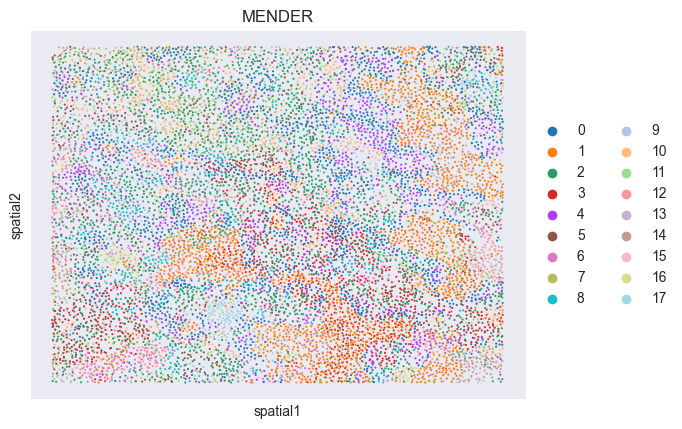

/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/study/anaconda3/envs/bioml/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


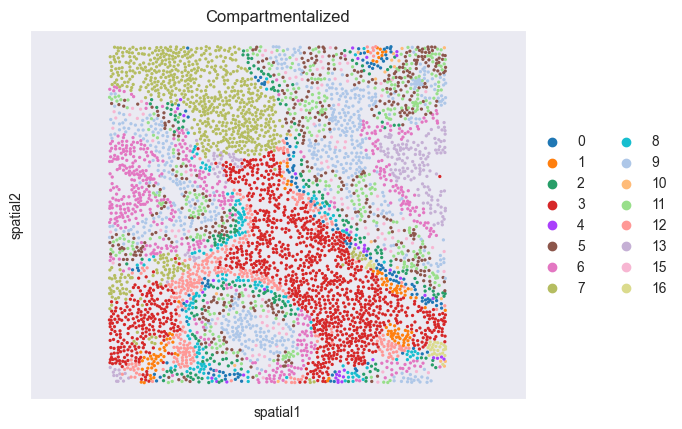

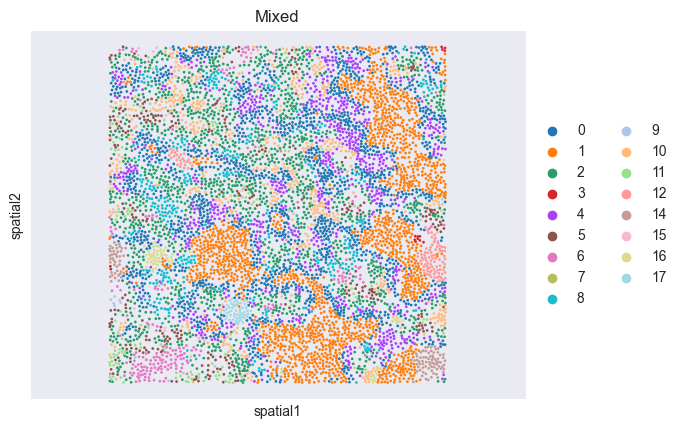

In [16]:
msm.output_cluster_all(obs='MENDER',obs_gt=None)
# plt.gca().invert_yaxis()
plt.show()